# Simple CNN for compare default parameters in further applications
#### Previous adversial ensemble network will be created in another file

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #If using Matplotlib on Windows with different versions, this will surpress error
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import statistics 
from scipy import ndimage #Image Smoothing
from collections import Counter

import sys
sys.path.append('../src/functions')
from clean_nn_weights import reset_weights    

#Git merge main/main master

Define dataloader parameter

In [2]:
batch_size_train = 32
batch_size_test = 32
random_seed = 1337
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.manual_seed(random_seed)  #Static random seed for reproducibility

Load MNIST Dataset from torchvision

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True, drop_last=True,worker_init_fn=random_seed)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True,drop_last=True,worker_init_fn=random_seed)

Load CIFAR10 Da taset from torchvision

In [63]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                torchvision.transforms.Resize(size=(28,28))
                             ])),
  batch_size=batch_size_train, shuffle=True, drop_last=True,worker_init_fn=random_seed)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                torchvision.transforms.Resize(size=(28,28))
                             ])),
  batch_size=batch_size_test, shuffle=True,drop_last=True,worker_init_fn=random_seed)

Files already downloaded and verified
Files already downloaded and verified


#### Quick analysis of class balances

In [48]:
print(train_loader.dataset.train_data.size())
print(test_loader.dataset.test_data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


f:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
f:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [41]:
nr_train = np.array([])
for i, (data, target) in enumerate(train_loader):
    nr_train=np.append(nr_train, target.cpu().detach().numpy())

nr_test = np.array([])
for i, (data, target) in enumerate(test_loader):
    nr_test=np.append(nr_test, target.cpu().detach().numpy())

In [14]:
Counter(np.sort(nr_train))

Counter({0.0: 6902,
         1.0: 7875,
         2.0: 6988,
         3.0: 7140,
         4.0: 6822,
         5.0: 6311,
         6.0: 6874,
         7.0: 7292,
         8.0: 6824,
         9.0: 6956})

In [11]:
Counter(np.sort(nr_test))

Counter({0.0: 979,
         1.0: 1133,
         2.0: 1030,
         3.0: 1009,
         4.0: 980,
         5.0: 890,
         6.0: 956,
         7.0: 1027,
         8.0: 973,
         9.0: 1007})

In [4]:
def extract_dataloader_images(epoch):
  #for batch_idx, (data, target) in enumerate(train_loader):
  examples = enumerate(test_loader,start=0)
  _, (example_data, example_targets) = next(examples)
  return(example_data, example_targets)

def count_perturbated_pixel(img1,img2):
  sum_px = 28*28
  sum_px_perturbed = 0
  for px_img1,px_img2 in zip(img1[0][0],img2[0][0]): #Zip Array of Pixels
    for px_im1,px_im2 in zip(px_img1,px_img2): #Zip Pixels
        if (px_im1 != px_im2):
            sum_px_perturbed+=1
  return((sum_px_perturbed/sum_px),sum_px,sum_px_perturbed)

def perturbate_image(img_data,mode='random',value=100):
  if (mode=='random'):
      for i in range(value):
          img_data[0][0][random.randrange(1,28),random.randrange(1,28)]=random.uniform(min(np.ravel(img_data)),max(np.ravel(img_data)))
  elif (mode=='random_white'):
      for i in range(value):
          img_data[0][0][random.randrange(1,28),random.randrange(1,28)]=round(max(np.ravel(img_data)))
  return(img_data)

def median_smoothing(img_data,kernel_size=2):
  from scipy import ndimage
  img_data_median = torch.clone(img_data)
  #print(img_data_median.shape.__len__())
  if (img_data_median.shape.__len__() > 2):
    for i in range(img_data_median.shape[0]):
      img_data_median[i][0] = torch.from_numpy(ndimage.median_filter(img_data_median[i][0], size=kernel_size))
  else:
    img_data_median = torch.from_numpy(ndimage.median_filter(img_data_median, size=kernel_size))
  return(img_data_median)

def bit_reduction(img_data,clip_min=0.499999,clip_max=0.5):
  img_data_bit = torch.clone(img_data)
  #todo add reduced_data clip normalization operations for batch 
  img_min = min(np.ravel(img_data_bit))
  img_max = max(np.ravel(img_data_bit))


  reduced_data = (img_data_bit-min(np.ravel(img_data_bit))) / (max(np.ravel(img_data_bit)) - min(np.ravel(img_data_bit)))
  reduced_data = reduced_data.clip(min=clip_min,max=clip_max)

  if (img_data_bit.shape.__len__() > 2):
    for i in range(img_data_bit.shape[0]):
      reduced_data[i][0][reduced_data[i][0]<clip_max] = torch.from_numpy(np.array(img_min))
      reduced_data[i][0][reduced_data[i][0]==clip_max] = torch.from_numpy(np.array(img_max))
  else:
    reduced_data[0][reduced_data[0]<clip_max] = torch.from_numpy(np.array(img_min))
    reduced_data[0][reduced_data[0]==clip_max] = torch.from_numpy(np.array(img_max))

  #reduced_data[reduced_data[0]==1]=img_max
  #reduced_data[reduced_data[0]==0]=img_min
  return(reduced_data)



def test_fake(data,use_network):
  use_network.eval()
  #network.eval()
  with torch.no_grad():
      output = use_network(data)
      return output

In [5]:
class ensemble_rectification(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(ensemble_rectification, self).__init__()

		#Net1
		self.conv1_1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1_1 = nn.ReLU()
		self.maxpool1_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2_1 = nn.Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2_1 = nn.ReLU()
		self.maxpool2_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2_drop_1 = nn.Dropout2d()

		self.fc1_1 = nn.Linear(in_features=800, out_features=500)
		self.relu3_1 = nn.ReLU()
		self.dropout_l_1 = nn.Dropout(p=0.5)
		self.fc2_1 = nn.Linear(in_features=500, out_features=classes)

		#Net2
		self.conv1_2 = nn.Conv2d(in_channels=numChannels, out_channels=30,
			kernel_size=(5, 5))
		self.relu1_2 = nn.ReLU()
		self.maxpool1_2 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2_2 = nn.Conv2d(in_channels=30, out_channels=75,
			kernel_size=(5, 5))
		self.relu2_2 = nn.ReLU()
		self.maxpool2_2 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2_drop_2 = nn.Dropout2d()

		self.fc1_2 = nn.Linear(in_features=1200, out_features=900)
		self.relu3_2 = nn.ReLU()
		self.dropout_l_2 = nn.Dropout(p=0.3)
		self.fc2_2 = nn.Linear(in_features=900, out_features=classes)

		#Net3
		self.conv1_3 = nn.Conv2d(in_channels=numChannels, out_channels=50,
			kernel_size=(5, 5))
		self.relu1_3 = nn.ReLU()
		self.maxpool1_3 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2_3 = nn.Conv2d(in_channels=50, out_channels=125,
			kernel_size=(5, 5))
		self.relu2_3 = nn.ReLU()
		self.maxpool2_3 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2_drop_3 = nn.Dropout2d()

		self.fc1_3 = nn.Linear(in_features=2000, out_features=1000)
		self.relu3_3 = nn.ReLU()
		self.dropout_l_3 = nn.Dropout(p=0.2)
		self.fc2_3 = nn.Linear(in_features=1000, out_features=classes)
			
	def forward(self, orig):
		x = self.conv1_1(orig)
		x = self.relu1_1(x)
		x = self.maxpool1_1(x)
		x = self.conv2_1(x)
		x = self.relu2_1(x)
		x = self.maxpool2_1(x)
		x = self.conv2_drop_1(x)
		x = torch.flatten(x, 1)
		x = self.fc1_1(x)
		x = self.relu3_1(x)
		x = self.dropout_l_1(x)
		x = self.fc2_1(x)

		y = self.conv1_2(orig)
		y = self.relu1_2(y)
		y = self.maxpool1_2(y)
		y = self.conv2_2(y)
		y = self.relu2_2(y)
		y = self.maxpool2_2(y)
		y = self.conv2_drop_2(y)
		y = torch.flatten(y, 1)
		y = self.fc1_2(y)
		y = self.relu3_2(y)
		y = self.dropout_l_2(y)
		y = self.fc2_2(y)

		z = self.conv1_3(orig)
		z = self.relu1_3(z)
		z = self.maxpool1_3(z)
		z = self.conv2_3(z)
		z = self.relu2_3(z)
		z = self.maxpool2_3(z)
		z = self.conv2_drop_3(z)
		z = torch.flatten(z, 1)
		z = self.fc1_3(z)
		z = self.relu3_3(z)
		z = self.dropout_l_3(z)
		z = self.fc2_3(z)

		concat = torch.cat([x, y, z], dim=1)

		return concat

In [13]:
network = ensemble_rectification(1,10)
network.apply(reset_weights)

Reset trainable parameters of layer = Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=800, out_features=500, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=10, bias=True)
Reset trainable parameters of layer = Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(30, 75, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1200, out_features=900, bias=True)
Reset trainable parameters of layer = Linear(in_features=900, out_features=10, bias=True)
Reset trainable parameters of layer = Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(50, 125, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=2000, out_features=1000, bias=True)
Reset trainable pa

ensemble_rectification(
  (conv1_1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1_1): ReLU()
  (maxpool1_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2_1): ReLU()
  (maxpool2_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2_drop_1): Dropout2d(p=0.5, inplace=False)
  (fc1_1): Linear(in_features=800, out_features=500, bias=True)
  (relu3_1): ReLU()
  (dropout_l_1): Dropout(p=0.5, inplace=False)
  (fc2_1): Linear(in_features=500, out_features=10, bias=True)
  (conv1_2): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
  (relu1_2): ReLU()
  (maxpool1_2): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2_2): Conv2d(30, 75, kernel_size=(5, 5), stride=(1, 1))
  (relu2_2): ReLU()
  (maxpool2_2): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2

In [21]:
class simple_net(nn.Module):
    def __init__(self):
        super(simple_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [22]:
class simple_net_upgraded(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=800, out_features=500)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.5)
		self.fc2 = nn.Linear(in_features=500, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [23]:
class simple_net_upgraded2(nn.Module): 											# This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded2, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=30,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2 = nn.Conv2d(in_channels=30, out_channels=75,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=1200, out_features=900)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.3)
		self.fc2 = nn.Linear(in_features=900, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [24]:
class simple_net_upgraded3(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded3, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=50,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2 = nn.Conv2d(in_channels=50, out_channels=125,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=2000, out_features=1000)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.2)
		self.fc2 = nn.Linear(in_features=1000, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [6]:
log_interval = 187 #60000/batch_size_train = 1875 => 10 Datapoints per Epoch => 187 Logs per Epoch
n_epochs = 20
learning_rate = 0.007
momentum = 0.5
load_data = 1
###########
use_upgraded_net = 1
use_ensemble = 1
use_integrated_ensemble = 1
##########
save_net = 0
##########

if (use_upgraded_net == 1):  
    if (use_ensemble == 1):
        if (use_integrated_ensemble==1):
            if  "CIFAR" in str(test_loader.dataset):
                network = ensemble_rectification(3,10)
                network.apply(reset_weights)
            elif "MNIST" in str(test_loader.dataset):
                network = ensemble_rectification(1,10)
                network.apply(reset_weights)
            print("Using integrated Ensemble")
        else:
            network = simple_net_upgraded(1,10)
            network2 = simple_net_upgraded2(1,10)
            network3 = simple_net_upgraded3(1,10)
            network.apply(reset_weights)
            network2.apply(reset_weights)
            network3.apply(reset_weights)
            print("Using Ensemble")
        
    
    else:
        network = simple_net_upgraded(1,10)
        network.apply(reset_weights)
        print ("Using Upgraded Net")
else:
    network = simple_net()
    network.apply(reset_weights)
    print ("Using Basic Net")


#device = "cuda:0"
#network.to(device)
if (use_ensemble == 0):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
if (use_ensemble == 1 and use_integrated_ensemble == 0):
    optimizer_ensemble = optim.SGD(list(network.parameters())+list(network2.parameters())+list(network3.parameters()), lr=learning_rate, momentum=momentum)
    print("Loaded Optimizer for Ensemble")
if (use_ensemble and use_integrated_ensemble):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

if (load_data and use_upgraded_net == 0):
    network.load_state_dict(torch.load('../src/results/model.pth'))
    print('Loaded model from file')
    optimizer.load_state_dict(torch.load('../src/results/optimizer.pth'))
    print('Loaded optimizer from basic model')
if (load_data and use_upgraded_net == 1):
    if (use_ensemble==1 and use_integrated_ensemble==0):
        network.load_state_dict(torch.load('../src/results/model_upgraded_ens.pth'))
        network2.load_state_dict(torch.load('../src/results/model2_upgraded_ens.pth'))
        network3.load_state_dict(torch.load('../src/results/model3_upgraded_ens.pth'))
        print('Loaded upgraded ensemble model from file')
        optimizer_ensemble.load_state_dict(torch.load('../src/results/optimizer_ensemble.pth'))
        print('Loaded ensemble optimizer from upgraded model')
    if (use_ensemble and use_integrated_ensemble):

        if  "CIFAR" in str(test_loader.dataset):
            network.load_state_dict(torch.load('../src/results/model_integrated_ens_cifar.pth'))
            print('Loaded integrated ensemble model for cifar from file')
            optimizer.load_state_dict(torch.load('../src/results/optimizer_integrated_cifar.pth'))
            print('Loaded optimizer from integrated ensemble model for cifar')
        else:
            network.load_state_dict(torch.load('../src/results/model_integrated_ens.pth'))
            print('Loaded integrated ensemble model from file')
            optimizer.load_state_dict(torch.load('../src/results/optimizer_integrated.pth'))
            print('Loaded optimizer from integrated ensemble model')

    if (use_ensemble==0 and use_integrated_ensemble==0):
        network.load_state_dict(torch.load('../src/results/model_upgraded_ens.pth'))
        print('Loaded upgraded model from file')
        optimizer.load_state_dict(torch.load('../src/results/optimizer_upgraded.pth'))
        print('Loaded optimizer from upgraded model')

if (save_net==1):
    print('WARNING: Saving model to file!! Will overwrite existing file!!!')

Reset trainable parameters of layer = Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=800, out_features=500, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=10, bias=True)
Reset trainable parameters of layer = Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(30, 75, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1200, out_features=900, bias=True)
Reset trainable parameters of layer = Linear(in_features=900, out_features=10, bias=True)
Reset trainable parameters of layer = Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(50, 125, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=2000, out_features=1000, bias=True)
Reset trainable pa

In [25]:
def train(epoch,use_ensemble=0,adversial_train=0):
  network.train()
  if (use_ensemble==1 and use_integrated_ensemble==0):
    network2.train()
    network3.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    if (use_ensemble == 1 and use_integrated_ensemble == 0):
      optimizer_ensemble.zero_grad()
      output1 = network(data)
      output2 = network2(data)
      output3 = network3(data)
      output = (output1 + output2 + output3)/3 # Average of three networks...not used here but it is usefull in test. You could also use the aggregated output as for the loss but that can result in false weight balancings when a specific model has made a false prediction. Need more literature checking!
      #loss = F.cross_entropy(output, target)
      #loss.backward()
      loss1 = F.cross_entropy(output1, target)
      loss2 = F.cross_entropy(output2, target)
      loss3 = F.cross_entropy(output3, target)
      loss = (loss1 + loss2 + loss3)
      loss.backward()
      optimizer_ensemble.step()
    else:
      optimizer.zero_grad()
      if (adversial_train):
        ########!
        fmodel = fb.PyTorchModel(model, bounds=(-0.4242129623889923, 2.821486711502075), device="cpu")
        attack = fb.attacks.FGSM()
        epsilons = [0.3] #, 0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0
        raw_advs, advs, is_adv = attack(fmodel, data, target, epsilons=epsilons)
        data = raw_advs[0]
      ########!
      output = network(data)
      loss = F.cross_entropy(output, target)
      loss.backward()
      optimizer.step()
    
    
    
    if (batch_idx % log_interval == 0) and (batch_idx != 0):
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      if (use_ensemble==1 and use_integrated_ensemble ==0):  
        print('Loss 1: {:.6f}'.format(loss1.item()))
        print('Loss 2: {:.6f}'.format(loss2.item()))
        print('Loss 3: {:.6f}'.format(loss3.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
#https://discuss.pytorch.org/t/optimizing-based-on-another-models-output/6935/14
#https://discuss.pytorch.org/t/using-a-combined-loss-to-update-two-different-models/73925
      

# Train difference value for adversial detection

In [71]:
def evaluate_threshold(network,train_loader,start,end,step,return_values=0):
  epsilons = []
  pertubation_ratio = []
  network.eval()
  with torch.no_grad():
    baseline_acc = test()
    while(start <= end):
      pertubated=0
      not_pertubated=0
      for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
      
        output = network(data)

        # Output median smoothed ensemble
        median_smoothed_batch=torch.clone(data)
        median_smoothed_batch = median_smoothing(median_smoothed_batch)
        output_ms = network(median_smoothed_batch)
        # Output bit reduced ensemble
        bit_reduced_batch=torch.clone(data)
        bit_reduced_batch = bit_reduction(bit_reduced_batch)
        output_br = network(bit_reduced_batch)
      
        pred = output.data.max(1, keepdim=True)[1]
        pred_ms = output_ms.data.max(1, keepdim=True)[1]
        pred_br = output_br.data.max(1, keepdim=True)[1]

        tensor_map_pred= F.softmax(output, dim=1)
        tensor_map_ms = F.softmax(output_ms, dim=1)
        tensor_map_br = F.softmax(output_br, dim=1)
      
        for x in range(len(pred)):
          difference_ms=(tensor_map_pred[x])-(tensor_map_ms[x])
          difference_br=(tensor_map_pred[x])-(tensor_map_br[x])
          distance_list=[max(difference_br).item(),max(difference_ms).item()]
          #difference_total = statistics.fmean(distance_list)
          difference_total = max(distance_list)
          #print("Max Tensor Distance:", difference_total)
          if (difference_total > start):
            pertubated+=1
            #print("Image is pertubated")
          else:
            not_pertubated+=1
            #print("Image is not pertubated")
      ratio=(100/len(train_loader.dataset))*not_pertubated
      epsilons.append(start)
      pertubation_ratio.append(ratio)
      print("Threshold {} with accuracy {}%".format(start,ratio))
      print("Threshold Accuracy/Baseline Accuracy diff: ",abs(baseline_acc.item()-ratio))
      print("Pertubated: {}".format(pertubated))
      print("Not Pertubated: {}".format(not_pertubated))
      print("#############################################")
      start+=step
  return(np.array(epsilons),np.array(pertubation_ratio),np.array(pertubated),np.array(not_pertubated))
  
      

In [72]:
ep, pert_ratio, pt, n_pt = evaluate_threshold(network,train_loader,start=0.005,end=0.050,step=0.005)


Test set: Avg. loss: 0.0007, Accuracy: 9920/10000 (99%)

Threshold 0.005 with accuracy 90.11%
Threshold Accuracy/Baseline Accuracy diff:  9.089996948242188
Pertubated: 5934
Not Pertubated: 54066
#############################################
Threshold 0.01 with accuracy 92.42%
Threshold Accuracy/Baseline Accuracy diff:  6.779996948242186
Pertubated: 4548
Not Pertubated: 55452
#############################################
Threshold 0.015 with accuracy 93.43833333333333%
Threshold Accuracy/Baseline Accuracy diff:  5.761663614908855
Pertubated: 3937
Not Pertubated: 56063
#############################################
Threshold 0.02 with accuracy 94.14666666666668%
Threshold Accuracy/Baseline Accuracy diff:  5.053330281575512
Pertubated: 3512
Not Pertubated: 56488
#############################################
Threshold 0.025 with accuracy 94.64%
Threshold Accuracy/Baseline Accuracy diff:  4.559996948242187
Pertubated: 3216
Not Pertubated: 56784
#############################################


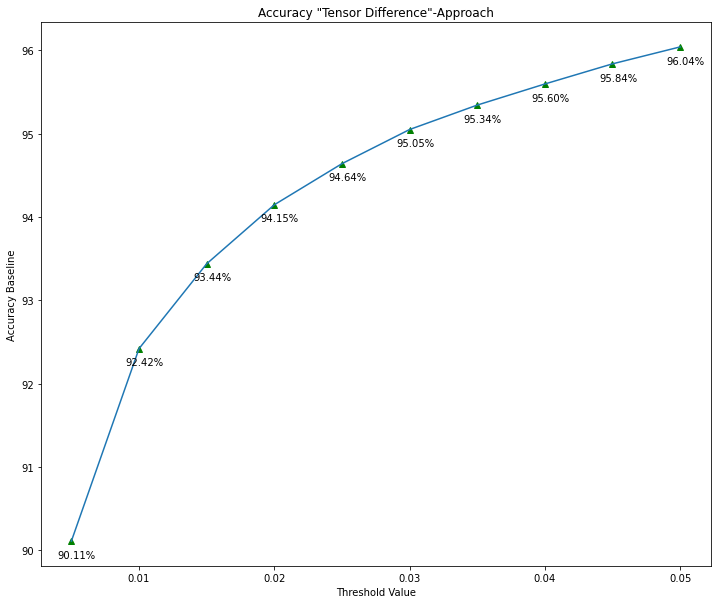

In [103]:

plt.figure(figsize=(12,10))
plt.xlabel('Threshold Value')
plt.ylabel('Accuracy Baseline')
plt.title('Accuracy "Tensor Difference"-Approach')

for i in range(len(pert_ratio)):
    plt.annotate("{:.2f}%".format(pert_ratio[i]), (ep[i]-0.001,pert_ratio[i]-0.2))
plt.plot(ep, pert_ratio, 'g^',ep,pert_ratio)

In [92]:
len(pert_ratio)

10

In [65]:
def test(use_ensemble=0):
  test_losses=[]
  test_acc = []
  network.eval()
  if (use_ensemble==1 and use_integrated_ensemble==0):
    network2.eval()
    network3.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      if (use_ensemble==1 and use_integrated_ensemble==0):
        output2 = network2(data)
        output3 = network3(data)
        output = (output + output2 + output3)/3# Average of three networks. Alternative is to use majority voting using output.data.max(1)[1] for each output and write it to an array to get argmax

      test_loss += F.cross_entropy(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  acc = 100. * correct / len(test_loader.dataset)
  test_acc.append(acc)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return(acc)

In [8]:
def test_conv_image_rect(use_ensemble=1):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    test_acc = []
    debug_output = 1
    network.eval()
    network2.eval()
    network3.eval()
    test_loss = 0
    correct = 0
    correct_ms = 0
    correct_br = 0
    correct_ensemble = 0
    pertubated = 0
    not_pertubated = 0
    with torch.no_grad():
        for data, target in test_loader:

            # Output original ensemble
            output = network(data)
            output2 = network2(data)
            output3 = network3(data)

            # Output median smoothed ensemble
            median_smoothed_batch=torch.clone(data)
            median_smoothed_batch = median_smoothing(median_smoothed_batch)
            output_ms = network(median_smoothed_batch)
            output2_ms = network2(median_smoothed_batch)
            output3_ms = network3(median_smoothed_batch)
            # Output bit reduced ensemble
            bit_reduced_batch=torch.clone(data)
            bit_reduced_batch = bit_reduction(bit_reduced_batch)
            output_br = network(bit_reduced_batch)
            output2_br = network2(bit_reduced_batch)
            output3_br = network3(bit_reduced_batch)

            # Average of three networks. Alternative is to use majority voting using output.data.max(1)[1] for each output and write it to an array to get argmax
            output = (output + output2 + output3)/3
            output_ms = (output_ms + output2_ms + output3_ms)/3
            output_br = (output_br + output2_br + output3_br)/3

            # Losses for each ensemble
            test_loss += F.cross_entropy(output, target).item()
            # To
            # Do

            # Test accuracy

            pred = output.data.max(1, keepdim=True)[1]
            pred_ms = output_ms.data.max(1, keepdim=True)[1]
            pred_br = output_br.data.max(1, keepdim=True)[1]

            tst= F.softmax(output, dim=1)
            tst_med = F.softmax(output_ms, dim=1)
            tst_scaled = F.softmax(output_br, dim=1)



            # Jury Vote for ensemble predictions
            jury_vote = []
            for x in range(len(pred)):
                votes = []
                first_vote = output.data.max(1, keepdim=True)[1][x].item()
                second_vote = output_ms.data.max(1, keepdim=True)[1][x].item()
                third_vote = output_br.data.max(1, keepdim=True)[1][x].item()
                votes.append(first_vote)
                votes.append(second_vote)
                votes.append(third_vote)
                jury_vote.append(np.bincount(votes).argmax())
                difference_ms=(tst[x])-(tst_med[x])
                difference_br=(tst[x])-(tst_scaled[x])


                distance_list=[max(difference_br).item(),max(difference_ms).item()]
                #difference_total = statistics.fmean(distance_list)
                difference_total = max(distance_list)
                #print("Max Tensor Distance:", difference_total)

                if (difference_total > 0.015):
                    pertubated+=1
                    #print("Image is pertubated")
                else:
                    not_pertubated+=1
                    #print("Image is not pertubated")
                
                if(target[x].item()==jury_vote[x]):
                    correct_ensemble += 1
                else:
                    print("Original target:",target[x].item(),"| Jury voted class:",jury_vote[x],"| Vanilla Ensemble Vote:" ,first_vote,"Median-Smoothed Ensemble Vote:",second_vote,"Bit-Reduced Ensemble Vote:",third_vote)
                    if (debug_output):
                        fig = plt.figure()
                        ax1 = fig.add_subplot(131)  # left side
                        ax2 = fig.add_subplot(132)  # right side
                        ax3 = fig.add_subplot(133)  # right side
                    
                        ax1.title.set_text("Original Image")
                        ax2.title.set_text("Median Smoothed Image")
                        ax3.title.set_text("Bit Reduced Image")

                        ax1.imshow(data[x][0], cmap='gray', interpolation='none')
                        ax2.imshow(median_smoothed_batch[x][0], cmap='gray', interpolation='none')
                        ax3.imshow(bit_reduced_batch[x][0], cmap='gray', interpolation='none')
                        fig.text(.5, .05, "Original Target: {}".format(target[x].item()), ha='center')
                        fig.set_figheight(5)
                        fig.set_figwidth(10)
                        plt.show()


            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ms += pred_ms.eq(target.data.view_as(pred_ms)).sum()
            correct_br += pred_br.eq(target.data.view_as(pred_br)).sum()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_acc.append(acc)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Accuracy_Median: {}, Accuracy_BitSmooth: {}, Accuracy_Ensemble: {}, perturbated_count: {}, not_perturbated_count: {}\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset), correct_ms, correct_br, correct_ensemble, pertubated, not_pertubated))
    

In [39]:
if  "cifar" in str(test_loader.dataset.filename):
    print("Hallo")

Hallo


In [38]:
str(test_loader.dataset.filename)

'cifar-10-python.tar.gz'

Original target: 9 | Jury voted class: 4 | Vanilla Ensemble Vote: 4 Median-Smoothed Ensemble Vote: 4 Bit-Reduced Ensemble Vote: 4


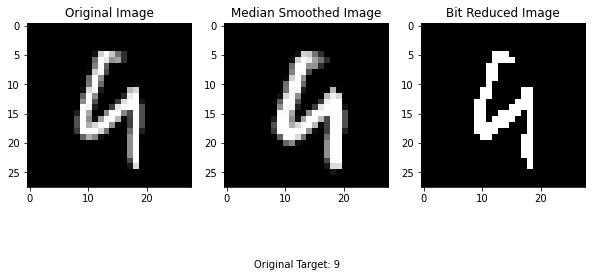

Original target: 9 | Jury voted class: 4 | Vanilla Ensemble Vote: 4 Median-Smoothed Ensemble Vote: 4 Bit-Reduced Ensemble Vote: 9


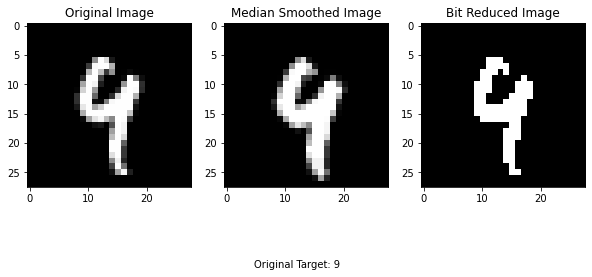

Original target: 1 | Jury voted class: 5 | Vanilla Ensemble Vote: 5 Median-Smoothed Ensemble Vote: 1 Bit-Reduced Ensemble Vote: 5


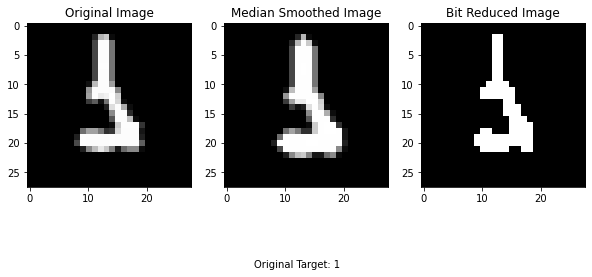

Original target: 2 | Jury voted class: 7 | Vanilla Ensemble Vote: 7 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 7


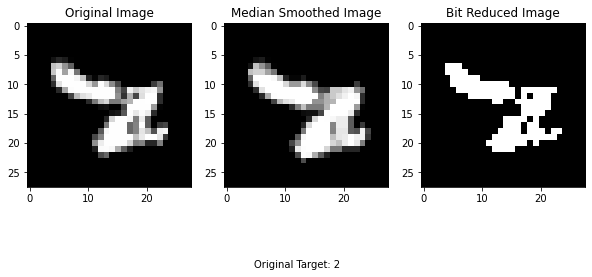

Original target: 4 | Jury voted class: 9 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 9


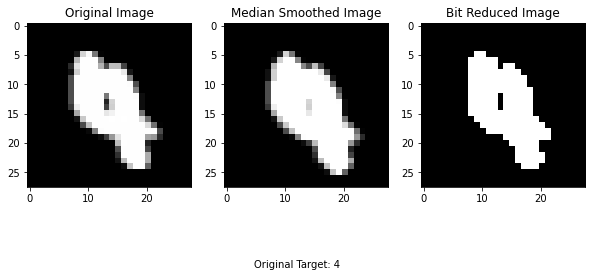

Original target: 0 | Jury voted class: 7 | Vanilla Ensemble Vote: 7 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 7


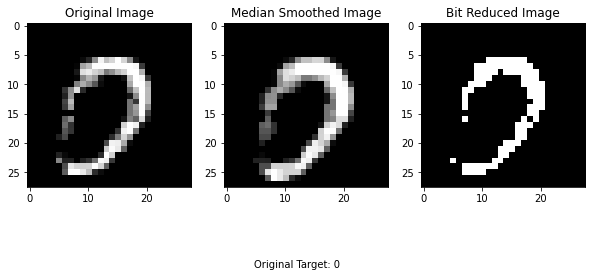

Original target: 6 | Jury voted class: 0 | Vanilla Ensemble Vote: 0 Median-Smoothed Ensemble Vote: 6 Bit-Reduced Ensemble Vote: 0


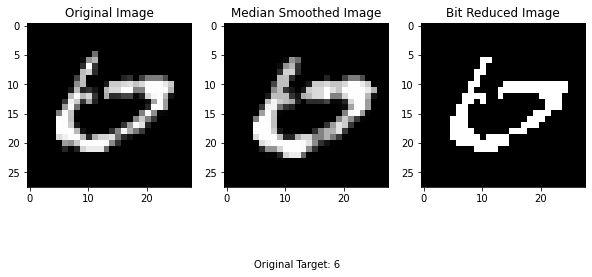

Original target: 6 | Jury voted class: 8 | Vanilla Ensemble Vote: 6 Median-Smoothed Ensemble Vote: 8 Bit-Reduced Ensemble Vote: 8


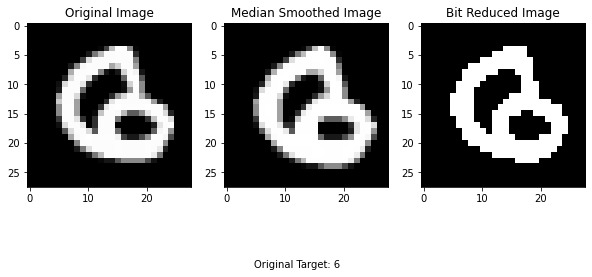

Original target: 9 | Jury voted class: 5 | Vanilla Ensemble Vote: 5 Median-Smoothed Ensemble Vote: 5 Bit-Reduced Ensemble Vote: 5


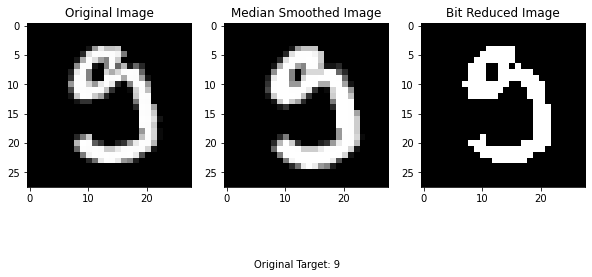

Original target: 9 | Jury voted class: 7 | Vanilla Ensemble Vote: 7 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 7


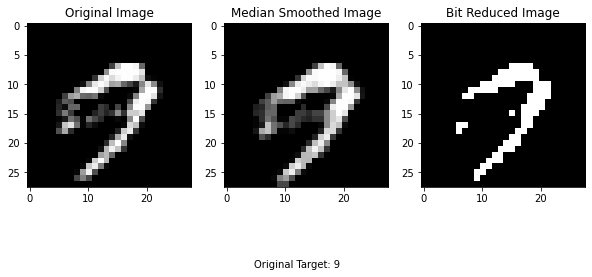

Original target: 6 | Jury voted class: 0 | Vanilla Ensemble Vote: 0 Median-Smoothed Ensemble Vote: 0 Bit-Reduced Ensemble Vote: 6


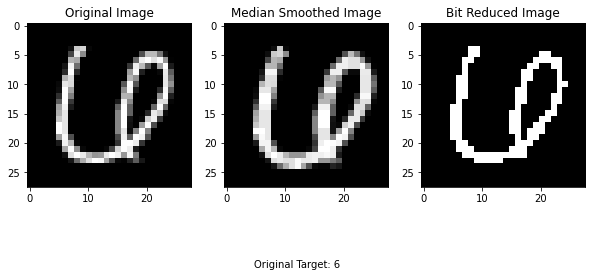

Original target: 8 | Jury voted class: 5 | Vanilla Ensemble Vote: 5 Median-Smoothed Ensemble Vote: 6 Bit-Reduced Ensemble Vote: 5


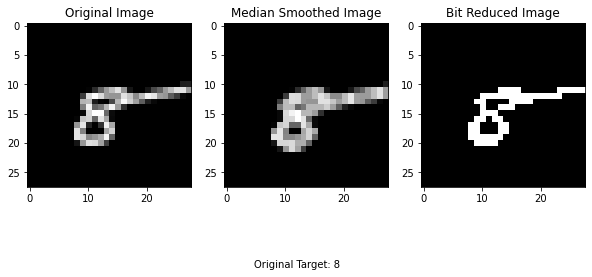

Original target: 6 | Jury voted class: 5 | Vanilla Ensemble Vote: 5 Median-Smoothed Ensemble Vote: 5 Bit-Reduced Ensemble Vote: 5


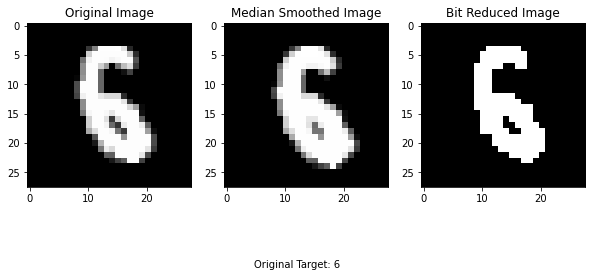

Original target: 6 | Jury voted class: 4 | Vanilla Ensemble Vote: 4 Median-Smoothed Ensemble Vote: 4 Bit-Reduced Ensemble Vote: 4


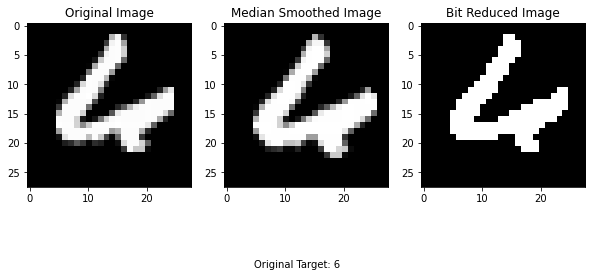

Original target: 9 | Jury voted class: 7 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 7


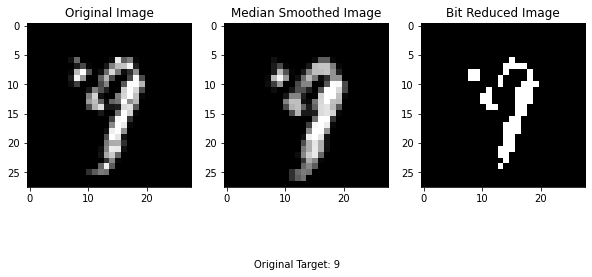

Original target: 6 | Jury voted class: 5 | Vanilla Ensemble Vote: 6 Median-Smoothed Ensemble Vote: 5 Bit-Reduced Ensemble Vote: 5


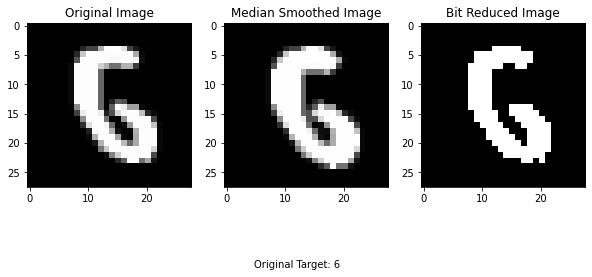

Original target: 5 | Jury voted class: 3 | Vanilla Ensemble Vote: 3 Median-Smoothed Ensemble Vote: 3 Bit-Reduced Ensemble Vote: 3


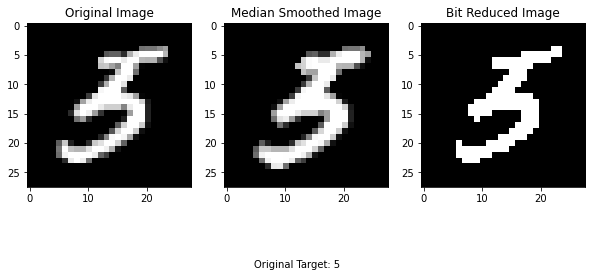

Original target: 3 | Jury voted class: 5 | Vanilla Ensemble Vote: 5 Median-Smoothed Ensemble Vote: 3 Bit-Reduced Ensemble Vote: 5


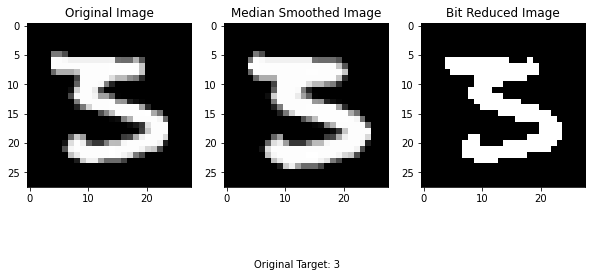

Original target: 3 | Jury voted class: 2 | Vanilla Ensemble Vote: 2 Median-Smoothed Ensemble Vote: 2 Bit-Reduced Ensemble Vote: 2


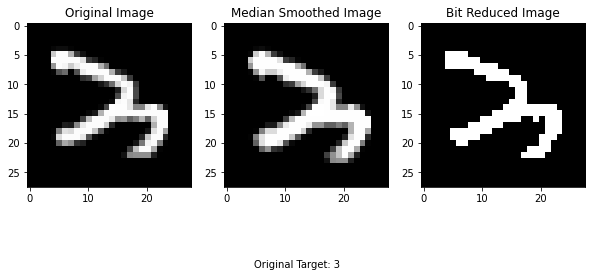

Original target: 2 | Jury voted class: 1 | Vanilla Ensemble Vote: 1 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 2


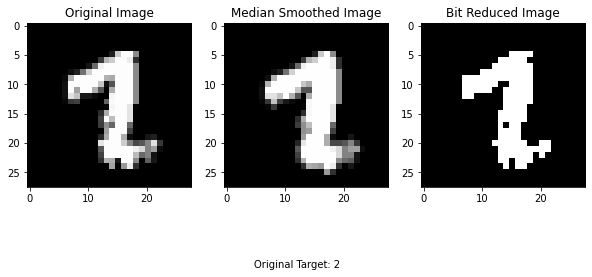

Original target: 2 | Jury voted class: 8 | Vanilla Ensemble Vote: 2 Median-Smoothed Ensemble Vote: 8 Bit-Reduced Ensemble Vote: 8


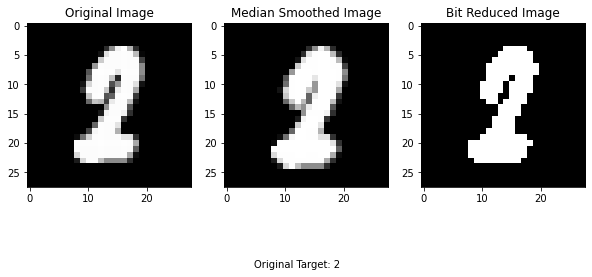

Original target: 2 | Jury voted class: 7 | Vanilla Ensemble Vote: 7 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 7


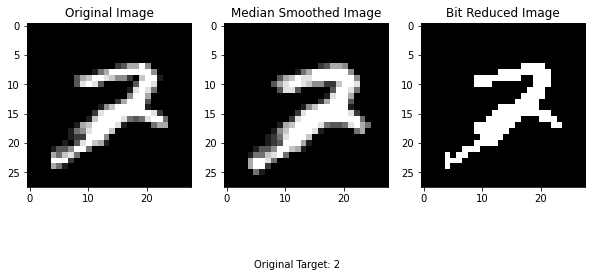

Original target: 8 | Jury voted class: 9 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 9


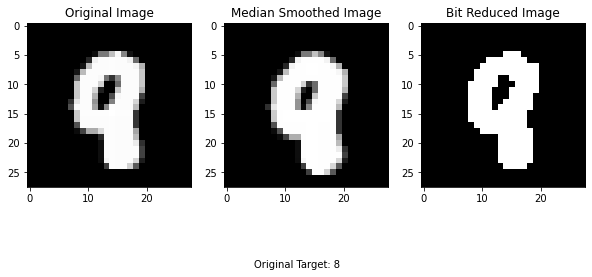

Original target: 8 | Jury voted class: 2 | Vanilla Ensemble Vote: 2 Median-Smoothed Ensemble Vote: 2 Bit-Reduced Ensemble Vote: 2


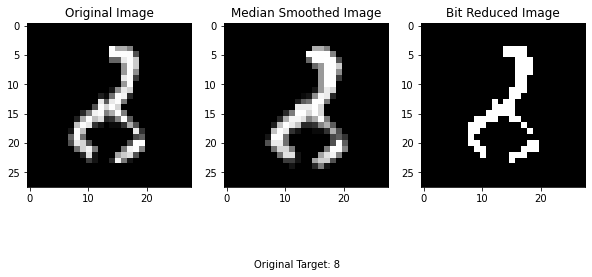

Original target: 7 | Jury voted class: 9 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 7


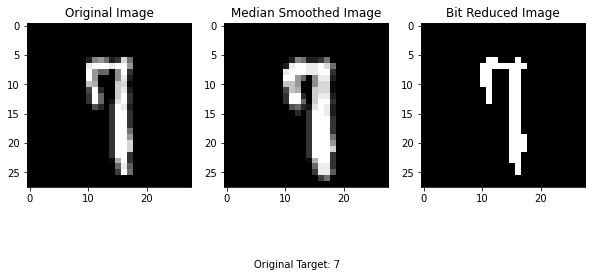

Original target: 3 | Jury voted class: 5 | Vanilla Ensemble Vote: 5 Median-Smoothed Ensemble Vote: 3 Bit-Reduced Ensemble Vote: 5


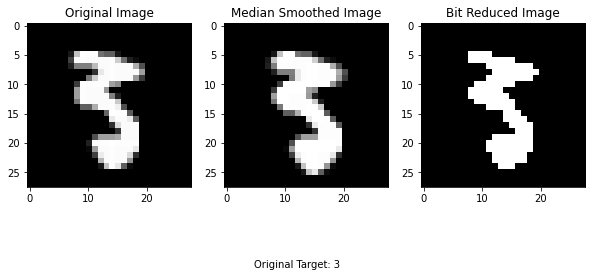

Original target: 0 | Jury voted class: 8 | Vanilla Ensemble Vote: 8 Median-Smoothed Ensemble Vote: 8 Bit-Reduced Ensemble Vote: 8


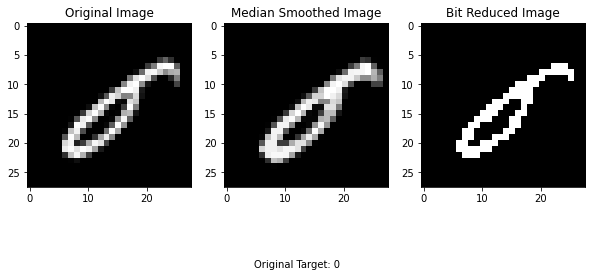

Original target: 9 | Jury voted class: 5 | Vanilla Ensemble Vote: 5 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 5


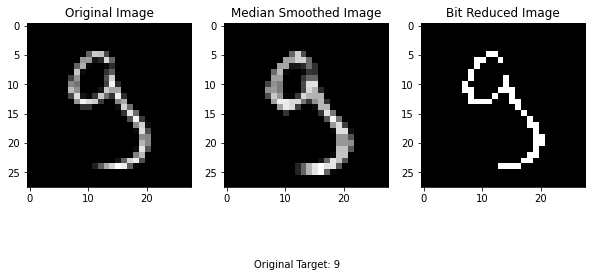

Original target: 5 | Jury voted class: 9 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 5


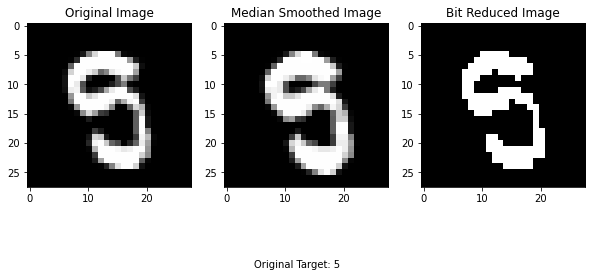

Original target: 5 | Jury voted class: 6 | Vanilla Ensemble Vote: 6 Median-Smoothed Ensemble Vote: 6 Bit-Reduced Ensemble Vote: 6


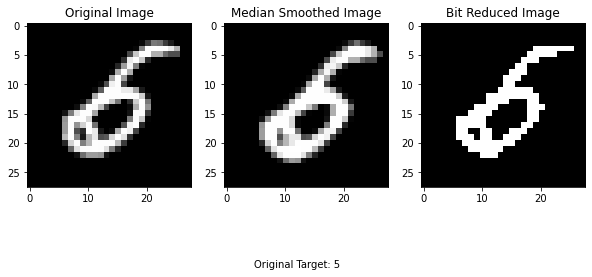

Original target: 5 | Jury voted class: 3 | Vanilla Ensemble Vote: 3 Median-Smoothed Ensemble Vote: 5 Bit-Reduced Ensemble Vote: 3


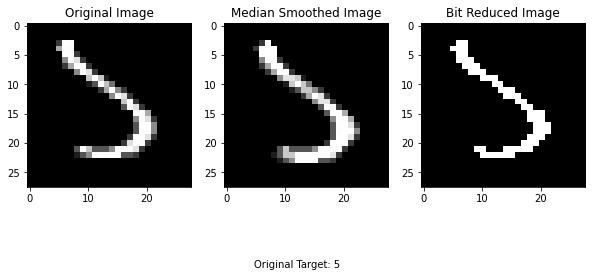

Original target: 9 | Jury voted class: 7 | Vanilla Ensemble Vote: 7 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 9


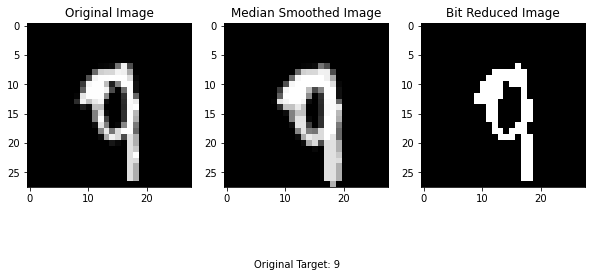

Original target: 6 | Jury voted class: 1 | Vanilla Ensemble Vote: 1 Median-Smoothed Ensemble Vote: 1 Bit-Reduced Ensemble Vote: 6


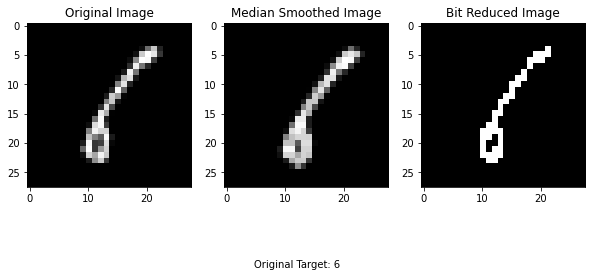

Original target: 1 | Jury voted class: 7 | Vanilla Ensemble Vote: 7 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 3


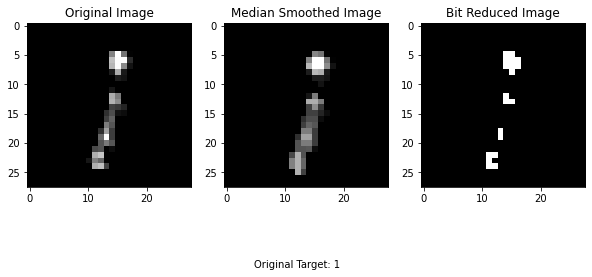

Original target: 4 | Jury voted class: 9 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 4


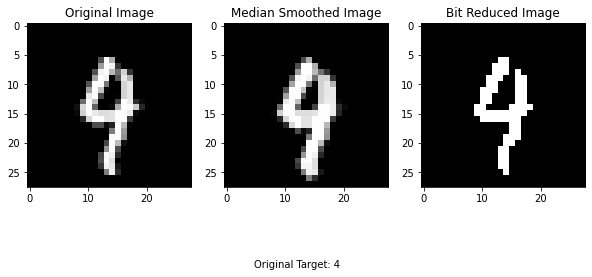

Original target: 7 | Jury voted class: 8 | Vanilla Ensemble Vote: 8 Median-Smoothed Ensemble Vote: 8 Bit-Reduced Ensemble Vote: 8


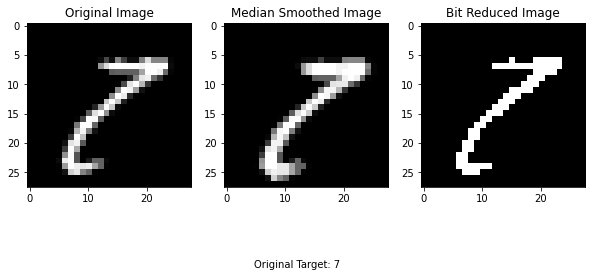

Original target: 8 | Jury voted class: 2 | Vanilla Ensemble Vote: 2 Median-Smoothed Ensemble Vote: 2 Bit-Reduced Ensemble Vote: 2


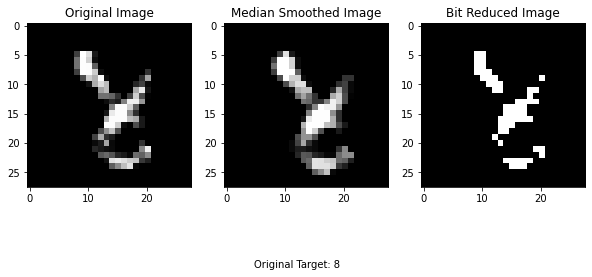

Original target: 7 | Jury voted class: 9 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 9


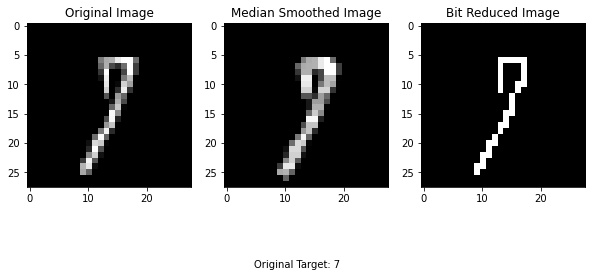

Original target: 5 | Jury voted class: 3 | Vanilla Ensemble Vote: 3 Median-Smoothed Ensemble Vote: 3 Bit-Reduced Ensemble Vote: 3


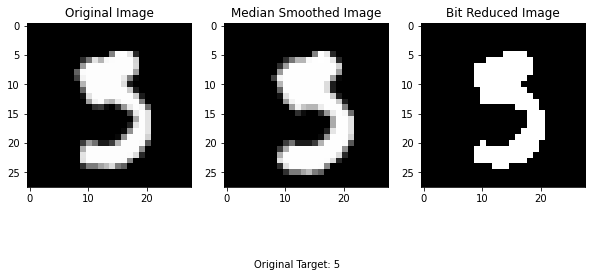

Original target: 7 | Jury voted class: 1 | Vanilla Ensemble Vote: 1 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 1


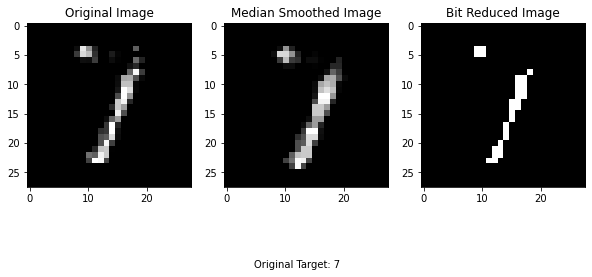

Original target: 6 | Jury voted class: 0 | Vanilla Ensemble Vote: 0 Median-Smoothed Ensemble Vote: 0 Bit-Reduced Ensemble Vote: 0


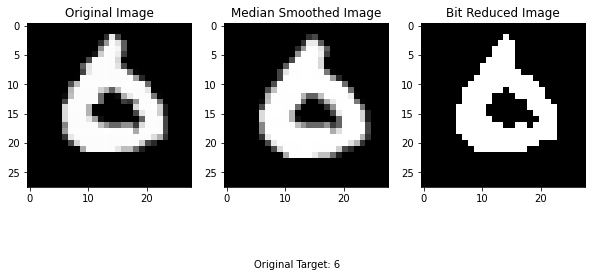

Original target: 9 | Jury voted class: 4 | Vanilla Ensemble Vote: 4 Median-Smoothed Ensemble Vote: 4 Bit-Reduced Ensemble Vote: 4


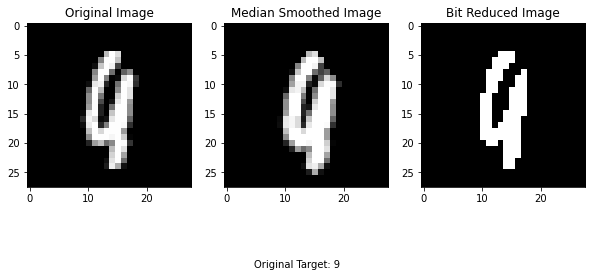

Original target: 6 | Jury voted class: 8 | Vanilla Ensemble Vote: 8 Median-Smoothed Ensemble Vote: 8 Bit-Reduced Ensemble Vote: 8


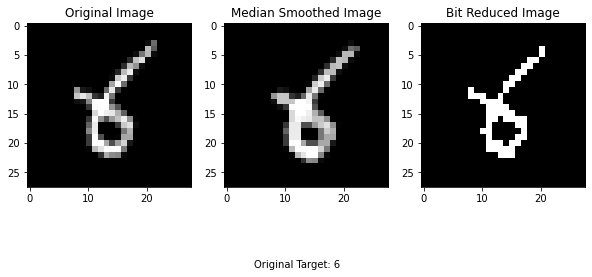

Original target: 6 | Jury voted class: 1 | Vanilla Ensemble Vote: 1 Median-Smoothed Ensemble Vote: 1 Bit-Reduced Ensemble Vote: 1


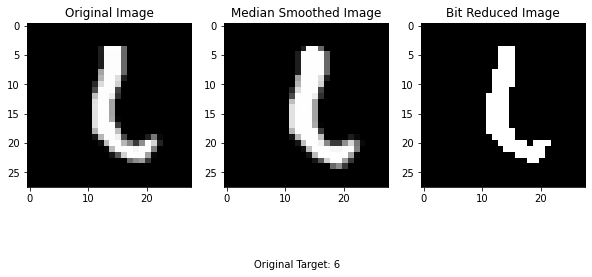

Original target: 7 | Jury voted class: 2 | Vanilla Ensemble Vote: 2 Median-Smoothed Ensemble Vote: 2 Bit-Reduced Ensemble Vote: 2


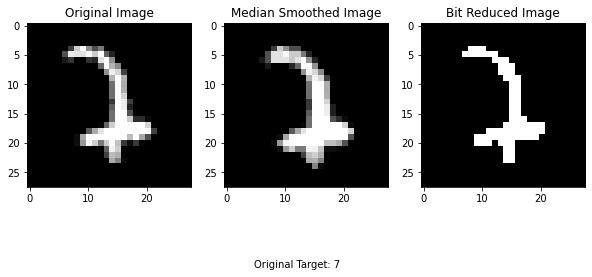

Original target: 3 | Jury voted class: 8 | Vanilla Ensemble Vote: 8 Median-Smoothed Ensemble Vote: 8 Bit-Reduced Ensemble Vote: 3


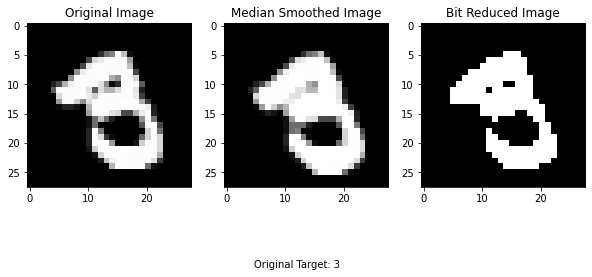

Original target: 9 | Jury voted class: 5 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 5 Bit-Reduced Ensemble Vote: 5


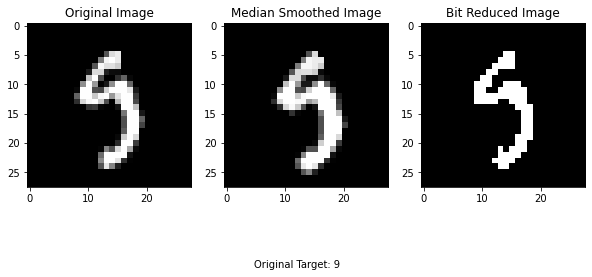

Original target: 1 | Jury voted class: 6 | Vanilla Ensemble Vote: 6 Median-Smoothed Ensemble Vote: 1 Bit-Reduced Ensemble Vote: 6


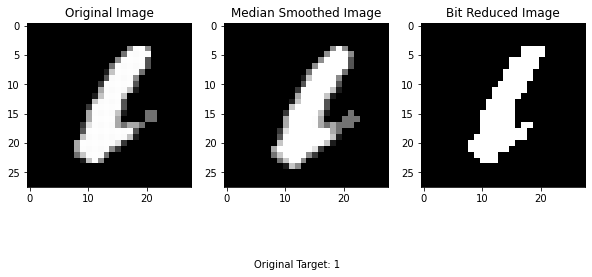

Original target: 6 | Jury voted class: 5 | Vanilla Ensemble Vote: 5 Median-Smoothed Ensemble Vote: 5 Bit-Reduced Ensemble Vote: 5


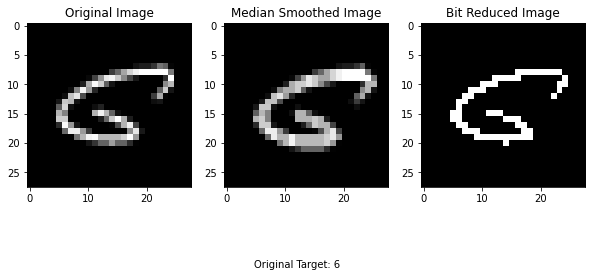

Original target: 5 | Jury voted class: 3 | Vanilla Ensemble Vote: 3 Median-Smoothed Ensemble Vote: 3 Bit-Reduced Ensemble Vote: 3


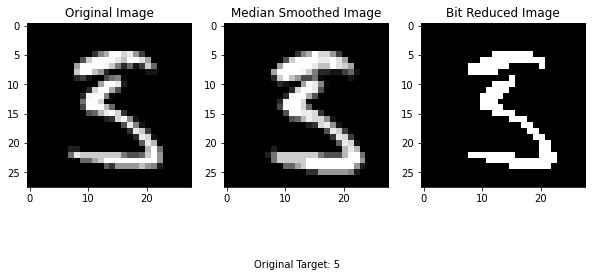

Original target: 4 | Jury voted class: 9 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 9


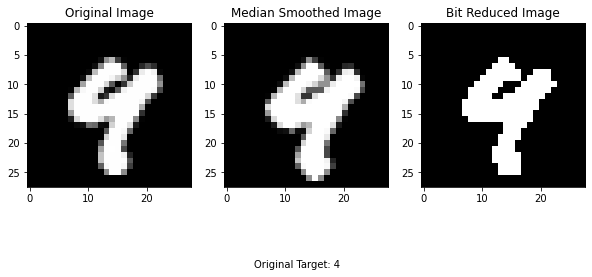

Original target: 7 | Jury voted class: 1 | Vanilla Ensemble Vote: 1 Median-Smoothed Ensemble Vote: 1 Bit-Reduced Ensemble Vote: 1


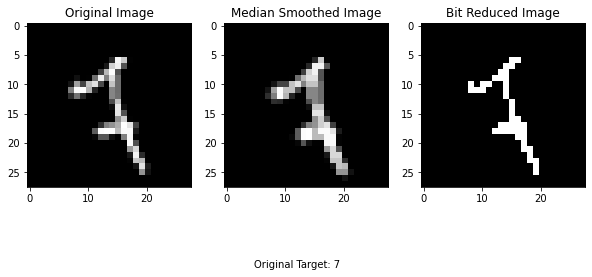

Original target: 9 | Jury voted class: 7 | Vanilla Ensemble Vote: 9 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 7


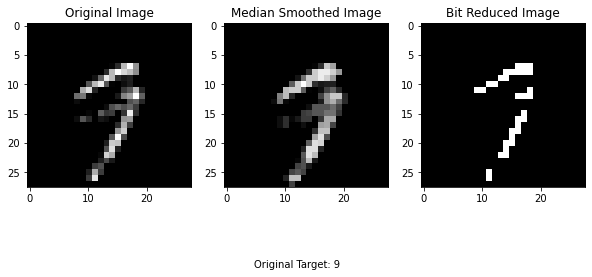

Original target: 8 | Jury voted class: 0 | Vanilla Ensemble Vote: 0 Median-Smoothed Ensemble Vote: 8 Bit-Reduced Ensemble Vote: 0


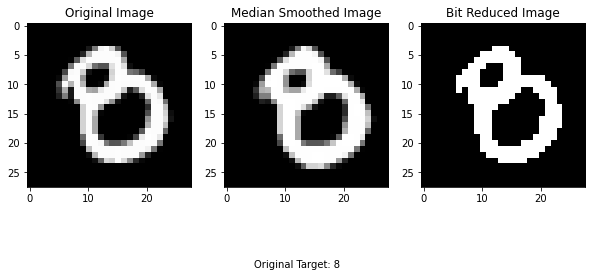

Original target: 9 | Jury voted class: 5 | Vanilla Ensemble Vote: 5 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 5


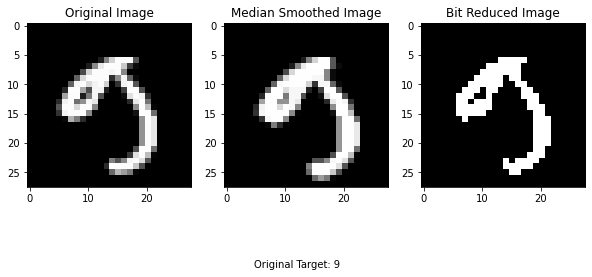

Original target: 6 | Jury voted class: 4 | Vanilla Ensemble Vote: 4 Median-Smoothed Ensemble Vote: 4 Bit-Reduced Ensemble Vote: 4


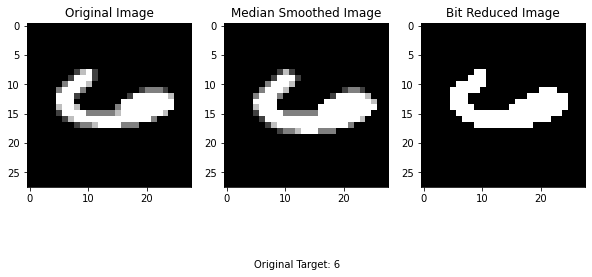

Original target: 9 | Jury voted class: 4 | Vanilla Ensemble Vote: 4 Median-Smoothed Ensemble Vote: 4 Bit-Reduced Ensemble Vote: 4


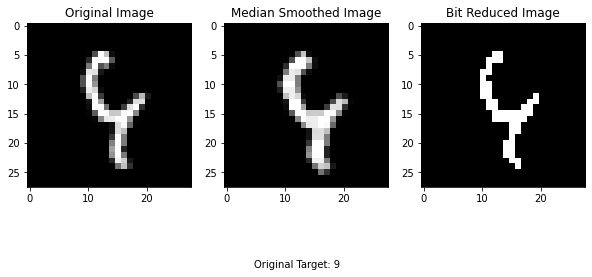


Test set: Avg. loss: 0.0005, Accuracy: 9929/10000 (99%), Accuracy_Median: 9901, Accuracy_BitSmooth: 9921, Accuracy_Ensemble: 9927, perturbated_count: 515, not_perturbated_count: 9469



In [145]:
test_conv_image_rect()

In [178]:
#0.001, pert=1430,n_pert=8554
#0.002, pert=1114,n_pert=8870
#0.003, pert=961,n_pert=9023
#0.004, pert=865,n_pert=9119
#0.005, pert=803,n_pert=9181
#0.006, pert=752,n_pert=9232
#0.007, pert=710,n_pert=9274
#0.008, pert=667,n_pert=9317
#0.009, pert=627,n_pert=9357
#0.010, pert=608,n_pert=9376
#0.011, pert=586,n_pert=9398
#0.012, pert=569,n_pert=9415
#0.013, pert=552,n_pert=9432
#0.014, pert=536,n_pert=9448
#0.015, pert=515,n_pert=9469
#0.020, pert=461,n_pert=9523
#0.025, pert=432,n_pert=9552
#0.030, pert=400,n_pert=9584

In [26]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc = []
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

if (use_upgraded_net==0 and save_net==1):
  torch.save(network.state_dict(), '../src/results/model.pth')
  torch.save(optimizer.state_dict(), '../src/results/optimizer.pth')
  print("Saved Modell to file")
elif (use_upgraded_net==1 and save_net==1):
  
  if (use_ensemble == 1 and use_integrated_ensemble == 0):
      torch.save(network.state_dict(), '../src/results/model_upgraded_ens.pth')
      torch.save(network2.state_dict(), '../src/results/model2_upgraded_ens.pth')
      torch.save(network3.state_dict(), '../src/results/model3_upgraded_ens.pth')
      torch.save(optimizer_ensemble.state_dict(), '../src/results/optimizer_ensemble.pth')
  if (use_ensemble == 1 and use_integrated_ensemble == 1):
      if  "cifar" in str(test_loader.dataset.filename):
        torch.save(network.state_dict(), '../src/results/model_integrated_ens_cifar.pth')
        torch.save(optimizer.state_dict(), '../src/results/optimizer_integrated_cifar.pth')
        print("Hello")
      else:
        torch.save(network.state_dict(), '../src/results/model_integrated_ens.pth')
        torch.save(optimizer.state_dict(), '../src/results/optimizer_integrated.pth')

  if (use_ensemble==0 and use_integrated_ensemble == 0):
      torch.save(network.state_dict(), '../src/results/model_upgraded.pth')
      torch.save(optimizer.state_dict(), '../src/results/optimizer_upgraded.pth')
  print("Saved Modell to file")
save_net = 0 #Secure that only one model is saved


Test set: Avg. loss: 0.1065, Accuracy: 627/10000 (6%)

Train Epoch: 1 [5984/50000 (12%)]	Loss: 2.073569
Train Epoch: 1 [11968/50000 (24%)]	Loss: 1.997082
Train Epoch: 1 [17952/50000 (36%)]	Loss: 1.760032
Train Epoch: 1 [23936/50000 (48%)]	Loss: 1.692300
Train Epoch: 1 [29920/50000 (60%)]	Loss: 1.845139
Train Epoch: 1 [35904/50000 (72%)]	Loss: 1.721915
Train Epoch: 1 [41888/50000 (84%)]	Loss: 1.960931
Train Epoch: 1 [47872/50000 (96%)]	Loss: 1.963584

Test set: Avg. loss: 0.0490, Accuracy: 4355/10000 (44%)

Train Epoch: 2 [5984/50000 (12%)]	Loss: 1.754009
Train Epoch: 2 [11968/50000 (24%)]	Loss: 1.677434
Train Epoch: 2 [17952/50000 (36%)]	Loss: 1.548920
Train Epoch: 2 [23936/50000 (48%)]	Loss: 1.641004
Train Epoch: 2 [29920/50000 (60%)]	Loss: 1.653393
Train Epoch: 2 [35904/50000 (72%)]	Loss: 1.949355
Train Epoch: 2 [41888/50000 (84%)]	Loss: 1.661766
Train Epoch: 2 [47872/50000 (96%)]	Loss: 1.473583

Test set: Avg. loss: 0.0440, Accuracy: 4873/10000 (49%)

Train Epoch: 3 [5984/50000 (12

In [42]:
save_net=1
if (use_upgraded_net==0 and save_net==1):
  torch.save(network.state_dict(), '../src/results/model.pth')
  torch.save(optimizer.state_dict(), '../src/results/optimizer.pth')
  print("Saved Modell to file")
elif (use_upgraded_net==1 and save_net==1):
  
  if (use_ensemble == 1 and use_integrated_ensemble == 0):
      torch.save(network.state_dict(), '../src/results/model_upgraded_ens.pth')
      torch.save(network2.state_dict(), '../src/results/model2_upgraded_ens.pth')
      torch.save(network3.state_dict(), '../src/results/model3_upgraded_ens.pth')
      torch.save(optimizer_ensemble.state_dict(), '../src/results/optimizer_ensemble.pth')
  if (use_ensemble == 1 and use_integrated_ensemble == 1):
      if  "cifar" in str(test_loader.dataset.filename):
        torch.save(network.state_dict(), '../src/results/model_integrated_ens_cifar.pth')
        torch.save(optimizer.state_dict(), '../src/results/optimizer_integrated_cifar.pth')
      else:
        torch.save(network.state_dict(), '../src/results/model_integrated_ens.pth')
        torch.save(optimizer.state_dict(), '../src/results/optimizer_integrated.pth')

  if (use_ensemble==0 and use_integrated_ensemble == 0):
      torch.save(network.state_dict(), '../src/results/model_upgraded.pth')
      torch.save(optimizer.state_dict(), '../src/results/optimizer_upgraded.pth')
  print("Saved Modell to file")
save_net = 0 #Secure that only one model is saved

Saved Modell to file


# Evaluate Baseline

In [46]:
def test_integrated_conv_image_rect():
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    test_acc = []
    debug_output = 0
    network.eval()
    test_loss = 0
    correct = 0
    correct_ms = 0
    correct_br = 0
    correct_ensemble = 0
    pertubated = 0
    not_pertubated = 0
    with torch.no_grad():
        for data, target in test_loader:

            # Output original ensemble
            output = network(data)

            # Output median smoothed ensemble
            median_smoothed_batch=torch.clone(data)
            median_smoothed_batch = median_smoothing(median_smoothed_batch)
            output_ms = network(median_smoothed_batch)

            # Output bit reduced ensemble
            bit_reduced_batch=torch.clone(data)
            bit_reduced_batch = bit_reduction(bit_reduced_batch)
            output_br = network(bit_reduced_batch)

            # Losses for each ensemble
            test_loss += F.cross_entropy(output, target).item()

            # Test accuracy
            pred = output.data.max(1, keepdim=True)[1]
            pred_ms = output_ms.data.max(1, keepdim=True)[1]
            pred_br = output_br.data.max(1, keepdim=True)[1]

            tst= F.softmax(output, dim=1)
            tst_med = F.softmax(output_ms, dim=1)
            tst_scaled = F.softmax(output_br, dim=1)



            # Jury Vote for ensemble predictions
            jury_vote = []
            for x in range(len(pred)):
                votes = []
                first_vote = output.data.max(1, keepdim=True)[1][x].item()
                second_vote = output_ms.data.max(1, keepdim=True)[1][x].item()
                third_vote = output_br.data.max(1, keepdim=True)[1][x].item()
                votes.append(first_vote)
                votes.append(second_vote)
                votes.append(third_vote)
                jury_vote.append(np.bincount(votes).argmax())
                difference_ms=(tst[x])-(tst_med[x])
                difference_br=(tst[x])-(tst_scaled[x])


                distance_list=[max(difference_br).item(),max(difference_ms).item()]
                #difference_total = statistics.fmean(distance_list)
                difference_total = max(distance_list)
                #print("Max Tensor Distance:", difference_total)

                if (difference_total > 0.015):
                    pertubated+=1
                    #print("Image is pertubated")
                else:
                    not_pertubated+=1
                    #print("Image is not pertubated")
                
                if(target[x].item()==jury_vote[x]):
                    correct_ensemble += 1
                else:
                    print("Original target:",target[x].item(),"| Jury voted class:",jury_vote[x],"| Vanilla Ensemble Vote:" ,first_vote,"Median-Smoothed Ensemble Vote:",second_vote,"Bit-Reduced Ensemble Vote:",third_vote)
                    if (debug_output):
                        fig = plt.figure()
                        ax1 = fig.add_subplot(131)  # left side
                        ax2 = fig.add_subplot(132)  # right side
                        ax3 = fig.add_subplot(133)  # right side
                    
                        ax1.title.set_text("Original Image")
                        ax2.title.set_text("Median Smoothed Image")
                        ax3.title.set_text("Bit Reduced Image")

                        ax1.imshow(data[x][0], cmap='gray', interpolation='none')
                        ax2.imshow(median_smoothed_batch[x][0], cmap='gray', interpolation='none')
                        ax3.imshow(bit_reduced_batch[x][0], cmap='gray', interpolation='none')
                        fig.text(.5, .05, "Original Target: {}".format(target[x].item()), ha='center')
                        fig.set_figheight(5)
                        fig.set_figwidth(10)
                        plt.show()


            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ms += pred_ms.eq(target.data.view_as(pred_ms)).sum()
            correct_br += pred_br.eq(target.data.view_as(pred_br)).sum()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc = 100. * correct_ensemble / len(test_loader.dataset)
    test_acc.append(acc)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Accuracy_Median: {}, Accuracy_BitSmooth: {}, Accuracy_Ensemble: {}, perturbated_count: {}, not_perturbated_count: {}\n'.format(
    test_loss, acc, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset), correct_ms, correct_br, correct_ensemble, pertubated, not_pertubated))
    

In [40]:
test_integrated_conv_image_rect()

Original target: 5 | Jury voted class: 3 | Vanilla Ensemble Vote: 3 Median-Smoothed Ensemble Vote: 3 Bit-Reduced Ensemble Vote: 3
Original target: 5 | Jury voted class: 0 | Vanilla Ensemble Vote: 0 Median-Smoothed Ensemble Vote: 0 Bit-Reduced Ensemble Vote: 5
Original target: 5 | Jury voted class: 3 | Vanilla Ensemble Vote: 3 Median-Smoothed Ensemble Vote: 3 Bit-Reduced Ensemble Vote: 3
Original target: 9 | Jury voted class: 7 | Vanilla Ensemble Vote: 7 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 7
Original target: 9 | Jury voted class: 7 | Vanilla Ensemble Vote: 7 Median-Smoothed Ensemble Vote: 9 Bit-Reduced Ensemble Vote: 7
Original target: 7 | Jury voted class: 2 | Vanilla Ensemble Vote: 2 Median-Smoothed Ensemble Vote: 7 Bit-Reduced Ensemble Vote: 2
Original target: 9 | Jury voted class: 4 | Vanilla Ensemble Vote: 4 Median-Smoothed Ensemble Vote: 4 Bit-Reduced Ensemble Vote: 4
Original target: 0 | Jury voted class: 6 | Vanilla Ensemble Vote: 6 Median-Smoothed Ensemb

In [10]:
device = torch.device("cpu")

In [43]:
import foolbox as fb
from torch.autograd import Variable
misclassified = 0
correct=0
correct_ens = 0
jury_vote = []
ensemble_class = []
accuracies=[]
test_acc=[]
distance_l0=0
distance_l2=0
distance_linf=0
runs = 0
from foolbox.criteria import Misclassification
# load data from dataloader
for i, data in enumerate(test_loader,0):
      runs+=1
      input, label = data
      input, label = Variable(input.to(device)), Variable(label.to(device))

      model = network.eval()

      
      # Generate adversial dataset for attack
      fmodel = fb.PyTorchModel(model, bounds=(-0.4242129623889923, 2.821486711502075), device="cpu")
      attack = fb.attacks.FGSM()
      epsilons = [1] #, 0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0
      criterion = Misclassification(label)
      raw_advs, advs, is_adv = attack(fmodel, input, label, epsilons=epsilons)

      # Use ensemble to jury classify the adversial dataset
      with torch.no_grad():
            output1 = model(median_smoothing(torch.clone(raw_advs[0])))
            output2 = model(bit_reduction(torch.clone(raw_advs[0])))
            output3 = model(torch.clone(raw_advs[0]))
            output = (output1 + output2 + output3)/3# Average of three networks. Alternative is to use majority voting using output.data.max(1)[1] for each output and write it to an array to get argmax

      pred = output.data.max(1, keepdim=True)[1]
      pred_br = output2.data.max(1, keepdim=True)[1]
      pred_ms = output3.data.max(1, keepdim=True)[1]
      
      jury_data = (list(zip(pred,pred_br,pred_ms)))
      for vote in range (len(jury_data)):
            if ((np.bincount(np.array(jury_data[vote])).argmax()) == label[vote].item()):
                  correct_ens+=1

      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(label.data.view_as(pred)).sum()
      acc = 100. * pred.eq(label.data.view_as(pred)).sum() / len(input)
      test_acc.append(acc)
      #!raw_advs_ens, _,success_ens = attack(fmodel, raw_advs[0], label, epsilons=epsilons)
      #!raw_advs_ms, _,success_ms = attack(fmodel, median_smoothing(torch.clone(raw_advs[0])), label, epsilons=epsilons)
      #!raw_advs_br, _,success_br = attack(fmodel, bit_reduction(torch.clone(raw_advs[0])), label, epsilons=epsilons)
      #!for batchitem in range(0,32):
      #!      jury_vote.append([(np.array(success_ms[0][batchitem]).astype(int)),(np.array(success_br[0][batchitem]).astype(int)),(np.array(is_adv[0][batchitem]).astype(int))])
      #!      ensemble_class.append(np.bincount(jury_vote[batchitem]).argmax())
      distance_l0+=(fb.distances.l0(raw_advs[0],input)/28).mean().item()    
      distance_l2+=(fb.distances.l2(raw_advs[0],input)/28).mean().item()    
      distance_linf+=(fb.distances.linf(raw_advs[0]/28,input)).mean().item()    
      #!jury_vote+=[[success_ens,success_ms,success_br]]
      misclassified+=np.count_nonzero(is_adv.cpu().view(-1).numpy())
      #print(np.count_nonzero(is_adv.cpu().view(-1).numpy()))
      #Prüfen warum ACC in acc-Test so gut aber als ensemble bincount so schlecht
      print("Accuracy: {}".format(fb.utils.accuracy(fmodel, raw_advs[0], label)))
      print("Accuracy_Ens: {}".format(acc))
      #!print("Accuracy Median: {}".format(fb.utils.accuracy(fmodel, median_smoothing(torch.clone(raw_advs[0])), label)))
      #!print("Accuracy BitReduced: {}".format(fb.utils.accuracy(fmodel, bit_reduction(torch.clone(raw_advs[0])), label)))
      accuracies.append(fb.utils.accuracy(fmodel, raw_advs[0], label))
      #!accuracies.append(fb.utils.accuracy(fmodel, median_smoothing(torch.clone(raw_advs[0])), label))
      #!accuracies.append(fb.utils.accuracy(fmodel, bit_reduction(torch.clone(raw_advs[0])), label))
#!print("Misclassified BaseNet:",misclassified)


print("Attack Success Rate: {}% with Epsylon {}".format(100/len(test_loader.dataset)*misclassified,epsilons))
print("Accuracy Baseline: {}".format(np.array(accuracies).mean()))
print("Accuracy image rectificated Outputs with pooled outputs: {}".format(np.array(test_acc).mean()))
print("Accuracy image rectificated Outputs Jury: {}".format(((100/len(test_loader.dataset))*correct_ens)))
#print("Attack Success Rate Ensemble: {}%".format(100/len(test_loader.dataset)*np.count_nonzero(ensemble_class)))
#print("Misclassified Image Rectification Ensemble:",np.count_nonzero(ensemble_class))
print("Distance L0: {}".format(distance_l0/runs))
print("Distance L2: {}".format(distance_l2/runs))
print("Distance Linf: {}".format(distance_linf/runs)) #Dont need to divide by runs because the distance is not averaged over the runs

Accuracy: 0.125
Accuracy_Ens: 46.875
Accuracy: 0.21875
Accuracy_Ens: 56.25
Accuracy: 0.21875
Accuracy_Ens: 46.875
Accuracy: 0.125
Accuracy_Ens: 53.125
Accuracy: 0.0625
Accuracy_Ens: 62.5
Accuracy: 0.125
Accuracy_Ens: 50.0
Accuracy: 0.0625
Accuracy_Ens: 43.75
Accuracy: 0.21875
Accuracy_Ens: 59.375
Accuracy: 0.21875
Accuracy_Ens: 46.875
Accuracy: 0.125
Accuracy_Ens: 53.125
Accuracy: 0.125
Accuracy_Ens: 56.25
Accuracy: 0.1875
Accuracy_Ens: 46.875
Accuracy: 0.0625
Accuracy_Ens: 43.75
Accuracy: 0.28125
Accuracy_Ens: 65.625
Accuracy: 0.21875
Accuracy_Ens: 68.75
Accuracy: 0.125
Accuracy_Ens: 53.125
Accuracy: 0.125
Accuracy_Ens: 59.375
Accuracy: 0.21875
Accuracy_Ens: 53.125
Accuracy: 0.28125
Accuracy_Ens: 65.625
Accuracy: 0.15625
Accuracy_Ens: 50.0
Accuracy: 0.125
Accuracy_Ens: 65.625
Accuracy: 0.1875
Accuracy_Ens: 59.375
Accuracy: 0.125
Accuracy_Ens: 43.75
Accuracy: 0.15625
Accuracy_Ens: 62.5
Accuracy: 0.09375
Accuracy_Ens: 68.75
Accuracy: 0.15625
Accuracy_Ens: 37.5
Accuracy: 0.125
Accuracy_E

In [ ]:
0.7285957147295659

In [44]:
print("Attack Success Rate: {}% with Epsylon {}".format(100/len(test_loader.dataset)*misclassified,epsilons))
print("Accuracy Baseline: {}".format(np.array(accuracies).mean()))
print("#############################################################################################################################")
print("Accuracy image rectificated Outputs with pooled outputs: {}".format(np.array(test_acc).mean()))
print("Accuracy image rectificated Outputs Jury: {}".format(((100/len(test_loader.dataset))*correct_ens)))
#print("Attack Success Rate Ensemble: {}%".format(100/len(test_loader.dataset)*np.count_nonzero(ensemble_class)))
#print("Misclassified Image Rectification Ensemble:",np.count_nonzero(ensemble_class))
print("Distance L0: {}".format(distance_l0/runs))
print("Distance L2: {}".format(distance_l2/runs))
print("Distance Linf: {}".format(distance_linf/runs))

Attack Success Rate: 83.98% with Epsylon [1]
Accuracy Baseline: 0.15885416666666666
#############################################################################################################################
Accuracy image rectificated Outputs with pooled outputs: 54.32692337036133
Accuracy image rectificated Outputs Jury: 54.99
Distance L0: 16.32256257534027
Distance L2: 0.7285986103308506
Distance Linf: 2.7508726792457776


In [39]:
fb.distances.linf(raw_advs[0],input)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [33]:
(fb.distances.linf(raw_advs[0],input)).mean().item()    

0.30000007152557373

In [17]:
aa = 0
for x in range(32):
    aa+=fb.distances.l0(raw_advs[0][x][0], input[x][0]).mean()
print(aa/32)

tensor(16.2098)


In [61]:
input[1][0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

In [11]:
output.data.max(1, keepdim=True)[1]

tensor([[8],
        [3],
        [6],
        [3],
        [6],
        [5],
        [6],
        [2],
        [3],
        [1],
        [6],
        [7],
        [7],
        [9],
        [6],
        [7],
        [9],
        [5],
        [2],
        [3],
        [1],
        [3],
        [3],
        [4],
        [9],
        [1],
        [4],
        [3],
        [4],
        [0],
        [2],
        [8]])

In [145]:
label

tensor([1, 0, 9, 8, 3, 2, 1, 0, 6, 9, 2, 8, 5, 1, 6, 4, 7, 0, 9, 9, 7, 9, 0, 5,
        8, 8, 5, 0, 6, 1, 5, 7])

In [113]:
np.array(jury_data[1]).argmax()

0

8

In [125]:
label[0].item()

6

In [315]:
print(success_ens.numpy().astype(int).mean().item() * 100)
print(success_ms.numpy().astype(int).mean().item() * 100)
print(success_br.numpy().astype(int).mean().item() * 100)

96.875
96.875
90.625


tensor([484., 505., 494., 497., 487., 566., 466., 461., 503., 491., 495., 496.,
        454., 528., 472., 469., 470., 487., 538., 505., 499., 451., 486., 478.,
        505., 441., 526., 468., 522., 489., 441., 496.])

In [164]:
input[0][0][6]

tensor([-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242,  0.2249,  2.0323,  2.8088,  2.7960,  2.5542,
         2.5415,  1.7778, -0.2969, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242])

In [165]:
advs[0][0][0][6]

tensor([-0.3242, -0.3242, -0.3242, -0.4242, -0.4242, -0.4242, -0.4242,  0.9104,
         2.8215,  2.8215,  2.6960,  2.6960,  2.6960,  2.6960,  2.6960,  2.6960,
         2.7088,  2.8215,  2.7815,  0.1340, -0.3242, -0.3242, -0.3242, -0.3242,
        -0.3242, -0.3242, -0.3242, -0.4242])

In [15]:
from foolbox.models import Model
import eagerpy as ep
from typing import Any
def accuracy_median(fmodel: Model, inputs: Any, labels: Any) -> float:
    inputs_ = median_smoothing(inputs)
    inputs_, labels_ = ep.astensors(inputs_, labels)
    del inputs, labels

    predictions = fmodel(inputs_).argmax(axis=-1)
    accuracy = (predictions == labels_).float32().mean()
    return accuracy.item()

def accuracy_bit(fmodel: Model, inputs: Any, labels: Any) -> float:
    inputs_ = bit_reduction(inputs)
    inputs_, labels_ = ep.astensors(inputs_, labels)
    del inputs, labels

    predictions = fmodel(inputs_).argmax(axis=-1)
    accuracy = (predictions == labels_).float32().mean()
    return accuracy.item()

def accuracy_ens() -> float:
    return((accuracy_median(fmodel, raw_advs[0], label)+accuracy_bit(fmodel, raw_advs[0], label)+fb.utils.accuracy(fmodel, raw_advs[0], label))/3)

In [16]:
print(accuracy_median(fmodel, raw_advs[0], label))
print(accuracy_bit(fmodel, raw_advs[0], label))
print(fb.utils.accuracy(fmodel, raw_advs[0], label))
print(accuracy_ens())

0.21875
1.0
0.1875
0.46875


In [84]:
print()
print("we can also manually check this:")
print()
from foolbox import PyTorchModel, accuracy, samples
print("robust accuracy for perturbations with")
for eps, advs_ in zip(epsilons, advs):
    acc2 = accuracy(fmodel, advs_, label)
    print(f"  Linf norm ≤ {eps:<6}: {acc2 * 100:4.1f} %")
    print("    perturbation sizes:")
    perturbation_sizes = (advs_ - input).norms.linf(axis=(1, 2, 3)).numpy()
    print("    ", str(perturbation_sizes).replace("\n", "\n" + "    "))
    if acc2 == 0:
        break


we can also manually check this:

robust accuracy for perturbations with
  Linf norm ≤ 0.0   : 100.0 %
    perturbation sizes:


AttributeError: 'Tensor' object has no attribute 'norms'

### Perturabation mesasurement

In [176]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)
print("Min: {}".format(min(np.ravel(x_d))))
print("Max: {}".format(max(np.ravel(x_d))))
print(abs(min(np.ravel(x_d))-max(np.ravel(x_d))))

Min: -0.4242129623889923
Max: 2.821486711502075
3.2456996


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

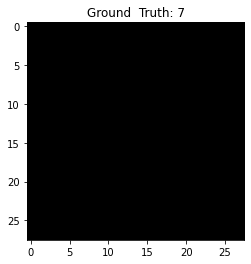

In [23]:
plt.imshow(scaled_data[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[0]))
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

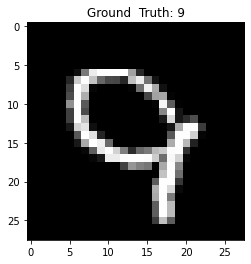

In [125]:
plt.imshow(f_d[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[0]))
plt.plot


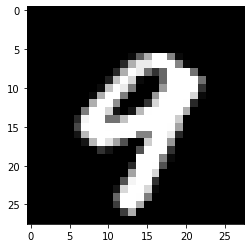

In [55]:
plt.imshow(ndimage.median_filter(f_d[0][0], size=2), cmap='gray', interpolation='none')

2


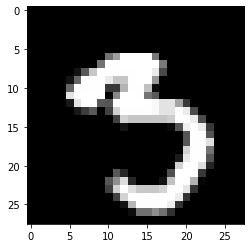

In [167]:
plt.imshow(median_smoothing(f_d[0][0]), cmap='gray', interpolation='none')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

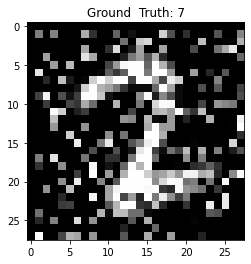

In [258]:
plt.imshow(pertubated_image[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[5]))
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

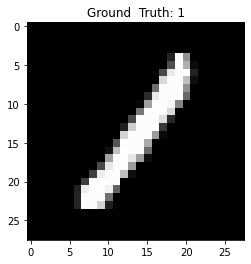

In [78]:
plt.imshow(x_d[5][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[5]))
plt.plot

In [163]:
median_smoothed = median_smoothing(f_d)
scaled_data = bit_reduction(f_d)
pertubated_image = perturbate_image(p_d,mode='random') #Pertubations seems to make in-place operations so use different tensor

In [189]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)

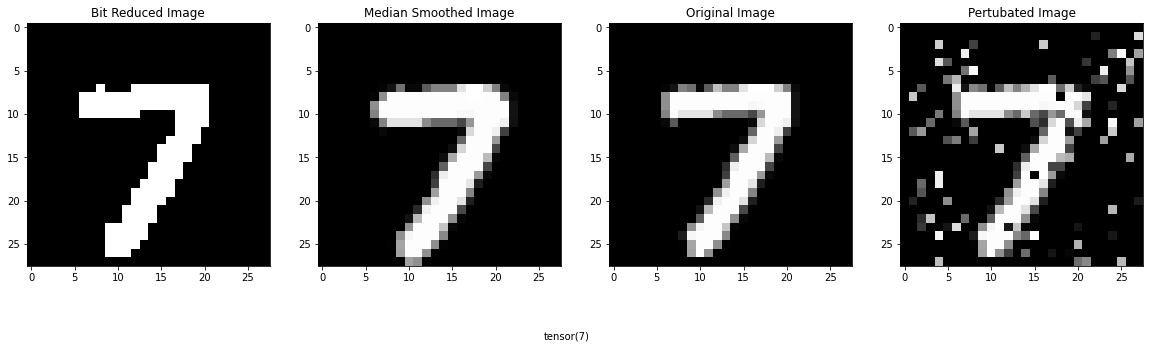

In [164]:
batch_nr = 0
fig = plt.figure()

ax1 = fig.add_subplot(141)  # left side
ax2 = fig.add_subplot(142)  # right side
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.title.set_text("Bit Reduced Image")
ax2.title.set_text("Median Smoothed Image")
ax3.title.set_text("Original Image")
ax4.title.set_text("Pertubated Image")
ax1.imshow(scaled_data[batch_nr][0], cmap='gray', interpolation='none')
ax2.imshow(median_smoothed[batch_nr][0], cmap='gray', interpolation='none')
ax3.imshow(x_d[batch_nr][0], cmap='gray', interpolation='none')
ax4.imshow(pertubated_image[batch_nr][0], cmap='gray', interpolation='none')
fig.text(.5, .05, e_d[batch_nr], ha='center')
fig.set_figheight(6)
fig.set_figwidth(20)
#plt.title("Ground  Truth: {}".format(e_d[batch_nr]))
plt.show()

### Test robustness of model

In [446]:
#networks= (network,network2,network3)
fake_tst = test_fake(f_d,network)

median_smoothed = median_smoothing(f_d)
scaled_data = bit_reduction(f_d)
pertubated_image = perturbate_image(p_d,mode='random') #Pertubations seems to make in-place operations so use different tensor

fake_tst_median = test_fake(median_smoothed,network)
fake_tst_scaled = test_fake(scaled_data,network)
fake_tst_perturbed = test_fake(pertubated_image,network)

p_percent,p_size,p_pertubated=count_perturbated_pixel(x_d[0][0],f_d[0][0])
print("Model predicted: {}".format(fake_tst.data.max(1, keepdim=True)[1][0]))
print("Model predicted median smoothed: {}".format(fake_tst_median.data.max(1, keepdim=True)[1][0]))
print("Model predicted scaled: {}".format(fake_tst_scaled.data.max(1, keepdim=True)[1][0]))
print("Model predicted perturbed: {}".format(fake_tst_perturbed.data.max(1, keepdim=True)[1][0]))
print("##################################################################")
print("Model predicted tensor value: {}".format(fake_tst.data.max(1)[0][0]))
print("Model predicted median smoothed tensor value: {}".format(fake_tst_median.data.max(1)[0][0]))
print("Model predicted scaled tensor value: {}".format(fake_tst_scaled.data.max(1)[0][0]))
print("Model predicted perturbed tensor value: {}".format(fake_tst_perturbed.data.max(1)[0][0]))
print("##################################################################")
print("Model real: {}".format(e_d[0]))
print("Sum pixel: {}".format(p_size))
print("Pertubated pixel: {}".format(p_pertubated))
print("Percent preturbated: {}".format(p_percent))

# Get prdicted tensor for normal model and squeezec models and calcluate the difference
# If difference is small, the image is not pertubated

TypeError: iteration over a 0-d tensor

In [167]:
tst= F.softmax(fake_tst, dim=1)
tst_med = F.softmax(fake_tst_median, dim=1)
tst_scaled = F.softmax(fake_tst_scaled, dim=1)
tst_perturbed = F.softmax(fake_tst_perturbed, dim=1)

In [86]:
tst[0]
tst_med[0]
tst_scaled[0]
tst_perturbed[0]

tensor([3.3206e-06, 1.1545e-06, 1.5094e-07, 3.8977e-03, 3.1818e-05, 9.0611e-01,
        9.5761e-06, 3.4804e-06, 4.9355e-02, 4.0588e-02])

In [168]:
difference=max(tst[0])-max(tst_perturbed[0])

In [169]:
print(format(difference, 'f'))

0.048123


# Tst perturbated example

Model predicted: tensor([2])
Model predicted median smoothed: tensor([2])
Model predicted scaled: tensor([2])
##################################################################
Model predicted tensor value: 19.3311767578125
Model predicted median smoothed tensor value: 19.64731216430664
Model predicted scaled tensor value: 19.95734405517578
##################################################################
Model real: 2
Sum pixel: 784
Pertubated pixel: 95
Percent preturbated: 0.1211734693877551


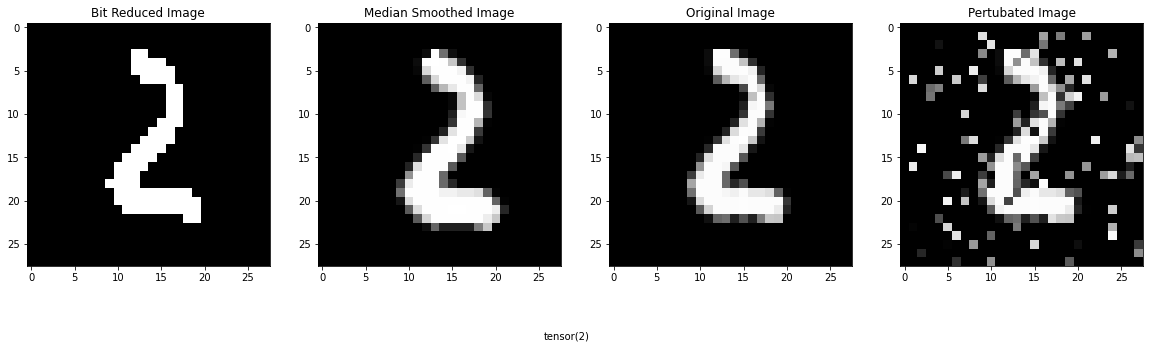

In [462]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)
#networks= (network,network2,network3)

pertubated_image = perturbate_image(p_d,mode='random') #Pertubations seems to make in-place operations so use different tensor
image = f_d
fake_tst = test_fake(image,network)

median_smoothed = median_smoothing(image)
scaled_data = bit_reduction(image)


fake_tst_median = test_fake(median_smoothed,network)
fake_tst_scaled = test_fake(scaled_data,network)


p_percent,p_size,p_pertubated=count_perturbated_pixel(x_d,pertubated_image)
print("Model predicted: {}".format(fake_tst.data.max(1, keepdim=True)[1][0]))
print("Model predicted median smoothed: {}".format(fake_tst_median.data.max(1, keepdim=True)[1][0]))
print("Model predicted scaled: {}".format(fake_tst_scaled.data.max(1, keepdim=True)[1][0]))

print("##################################################################")
print("Model predicted tensor value: {}".format(fake_tst.data.max(1)[0][0]))
print("Model predicted median smoothed tensor value: {}".format(fake_tst_median.data.max(1)[0][0]))
print("Model predicted scaled tensor value: {}".format(fake_tst_scaled.data.max(1)[0][0]))

print("##################################################################")
print("Model real: {}".format(e_d[0]))
print("Sum pixel: {}".format(p_size))
print("Pertubated pixel: {}".format(p_pertubated))
print("Percent preturbated: {}".format(p_percent))

####

batch_nr = 0
fig = plt.figure()

ax1 = fig.add_subplot(141)  # left side
ax2 = fig.add_subplot(142)  # right side
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.title.set_text("Bit Reduced Image")
ax2.title.set_text("Median Smoothed Image")
ax3.title.set_text("Original Image")
ax4.title.set_text("Pertubated Image")
ax1.imshow(scaled_data[batch_nr][0], cmap='gray', interpolation='none')
ax2.imshow(median_smoothed[batch_nr][0], cmap='gray', interpolation='none')
ax3.imshow(x_d[batch_nr][0], cmap='gray', interpolation='none')
ax4.imshow(pertubated_image[batch_nr][0], cmap='gray', interpolation='none')
fig.text(.5, .05, e_d[batch_nr], ha='center')
fig.set_figheight(6)
fig.set_figwidth(20)
#plt.title("Ground  Truth: {}".format(e_d[batch_nr]))
plt.show()


In [463]:
tst= F.softmax(fake_tst, dim=1)
tst_med = F.softmax(fake_tst_median, dim=1)
tst_scaled = F.softmax(fake_tst_scaled, dim=1)
difference_ms=(tst[0])-(tst_med[0])
difference_br=(tst[0])-(tst_scaled[0])


In [464]:

print(max(difference_ms))
print(max(difference_br))
distance_list=[max(difference_br).item(),max(difference_ms).item()]
#difference_total = statistics.fmean(distance_list)
difference_total = max(distance_list)
print("Max Tensor Distance:", difference_total)

if (difference_total > 0.00005):
    print("Image is pertubated")
else:
    print("Image is not pertubated")

tensor(2.3842e-07)
tensor(1.5251e-07)
Max Tensor Distance: 2.384185791015625e-07
Image is not pertubated


In [32]:
%run "c:\GIT\Programme\code\Master\Koch\Robustness of Generative Adversial Networks\src\Models\upgraded_net_hook.py"

In [31]:
%run "c:\GIT\Programme\code\Master\Koch\Robustness of Generative Adversial Networks\src\functions\f2d.py"

upgraded_net_hook.nn

Train:


AttributeError: module 'upgraded_net_hook' has no attribute 'ResNet20'